# Использование auto_arima для прогнозирования временного ряда

In [1]:
!pip install pmdarima -q
!pip install tqdm -q

     |████████████████████████████████| 1.4 MB 9.4 MB/s 
     |████████████████████████████████| 9.8 MB 32.9 MB/s 


In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm_notebook
import numpy as np
import datetime
import pmdarima as pm

## Прогнозирование исходных данных

В качестве показательных данных используются акции компании Apple с секундной градулярностью, всего данные взяты за месяц.

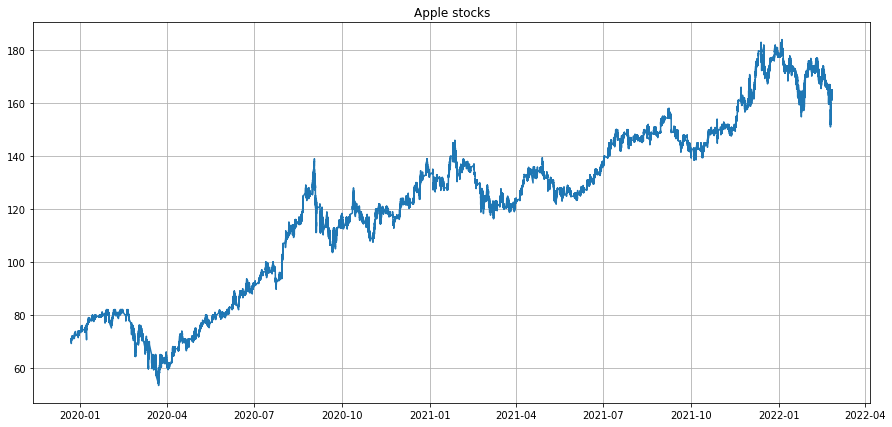

In [3]:
file = 'data/AAPL.csv'
dataset = pd.read_csv(file, index_col='time', parse_dates=['time'])
data = dataset.loc[:, 'close']  # значения акции
data = data.to_frame()
data = data.sort_index()  # сортировка по дате (изначально данные не сортированы)

plt.figure(figsize=(15, 7))
plt.plot(data)
plt.title('Apple stocks')
plt.grid(True)
plt.show()

График получился немного прерывистым из-за наличия пропусков в данных.

In [ ]:
data.shape

(538237, 1)

In [ ]:
data.head()

,close
time,
2019-12-23 07:01:00+00:00,70.7750
2019-12-23 07:03:00+00:00,70.1225
2019-12-23 07:04:00+00:00,70.1175
2019-12-23 07:05:00+00:00,69.8875
2019-12-23 07:06:00+00:00,70.1150


In [ ]:
data.tail()

,close
time,
2022-02-25 22:40:00+00:00,164.60
2022-02-25 22:41:00+00:00,164.61
2022-02-25 22:42:00+00:00,164.57
2022-02-25 22:43:00+00:00,164.60
2022-02-25 22:44:00+00:00,164.60


Построение auto_arima модели.

In [ ]:
smodel = pm.auto_arima(data, 
                       start_p=1, max_p=3,
                       start_q=1, max_q=3,
                       start_P=0, max_P=5,
                       start_Q=0, max_Q=5,
                       test='adf',  # ADF-тест для установления стационарности
                       seasonal=True, m=7,  # сезонность по суткам
                       d=1, 
                       D=None, 
                       trace=True,
                       error_action='warn',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

Составим прогноз данных на сутки

In [ ]:
n_periods = 5  # days
n_periods_per_hours = 120  # hours
n_periods_per_minutes = 1440  # minutes = 24 hours
fitted, confint = smodel.predict(n_periods=n_periods_per_minutes, return_conf_int=True)
index_of_fc = pd.date_range(start=data.index[-1], periods = n_periods_per_minutes, freq='T')

fitted_series = pd.DataFrame(fitted, index=index_of_fc, columns=['Value'])

In [ ]:
fitted_series

,Value
2022-01-31 13:47:58-05:00,173.231193
2022-01-31 13:48:58-05:00,173.227442
2022-01-31 13:49:58-05:00,173.230244
2022-01-31 13:50:58-05:00,173.239516
2022-01-31 13:51:58-05:00,173.239887
...,...
2022-02-01 13:42:58-05:00,173.237843
2022-02-01 13:43:58-05:00,173.237843
2022-02-01 13:44:58-05:00,173.237843
2022-02-01 13:45:58-05:00,173.237843


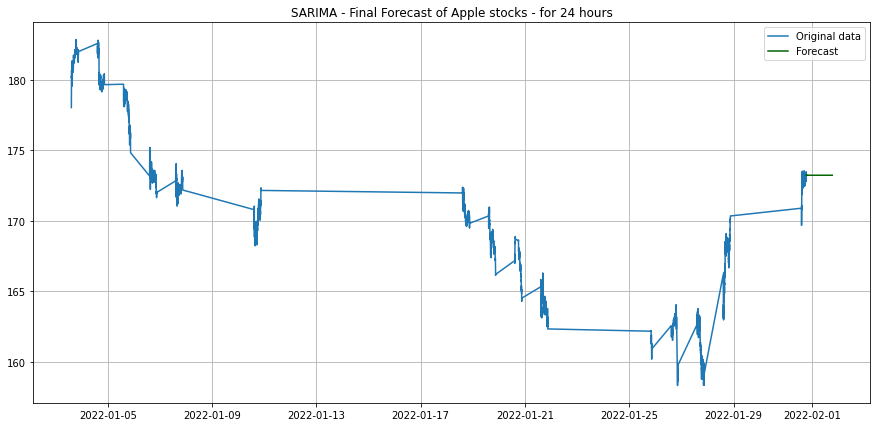

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(data, label='Original data')
plt.plot(fitted_series, color='darkgreen', label='Forecast')
plt.title("SARIMA - Final Forecast of Apple stocks - for 24 hours")
plt.grid(True)
plt.legend()
plt.show()

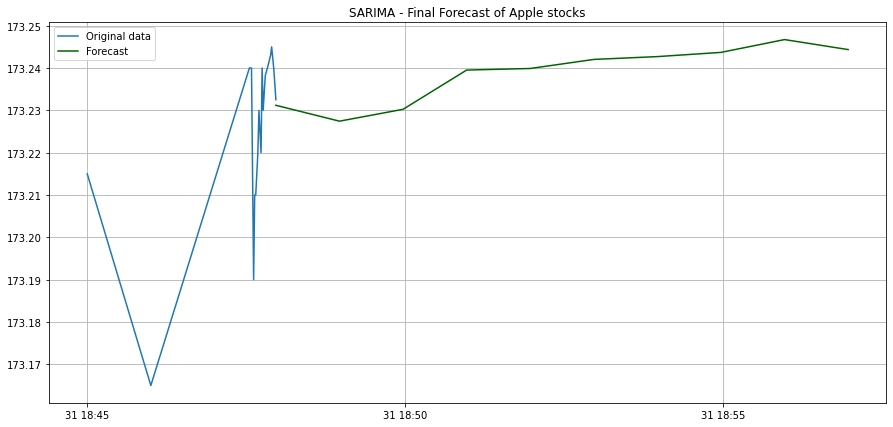

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(data[4900:], label='Original data')
plt.plot(fitted_series[:10], color='darkgreen', label='Forecast')
plt.title("SARIMA - Final Forecast of Apple stocks")
plt.grid(True)
plt.legend()
plt.show()

## Прогнозирование аггрегированных данных

Аггрегируем данные по дням и составим прогноз на 5 дней.

In [4]:
data_aggregate = data.resample('D').mean()
data_aggregate = data_aggregate.fillna(data_aggregate.bfill())
data_aggregate.isnull().sum()

close    0
dtype: int64

In [ ]:
data_aggregate.shape

(796, 1)

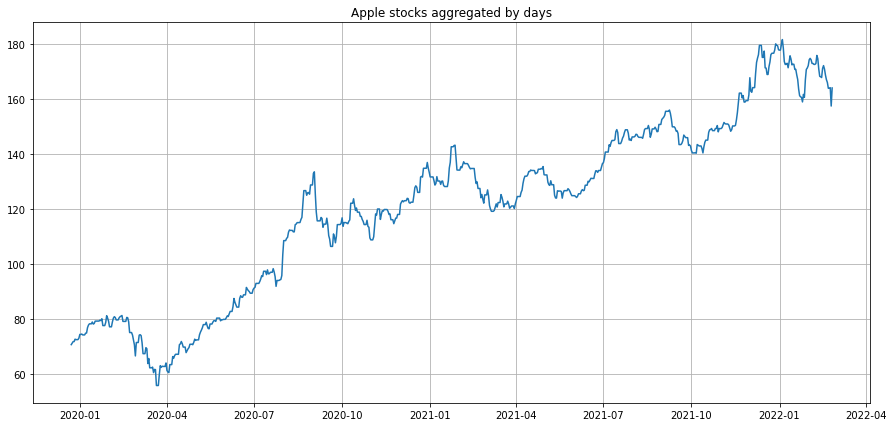

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(data_aggregate)
plt.title('Apple stocks aggregated by days')
plt.grid(True)
plt.show()

In [5]:
smodel_agg = pm.auto_arima(data_aggregate, 
                       start_p=1, max_p=3,
                       start_q=1, max_q=3,
                       start_P=0, max_P=5,
                       start_Q=0, max_Q=5,
                       test='adf',  # ADF-тест для установления стационарности
                       seasonal=True, m=7,  # сезонность по суткам
                       d=1, 
                       D=None, 
                       trace=True,
                       error_action='warn',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel_agg.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=3029.212, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3049.377, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3027.760, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3027.752, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3051.425, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3027.219, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3027.716, Time=0.24 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3029.654, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=3029.216, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=3027.495, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=3031.133, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[7]             : AIC=3028.316, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[7] intercept
Total fit time: 2.925 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  796
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1510.609
Date:                Fri, 18 Mar 2022   AIC                           3027.219
Time:                        20:43:04   BIC                           3041.254
Sample:                             0   HQIC                          3032.612
                                - 796                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1192      0.068      1.758      0.079      -0.014       0.252
ma.L1          0.1777      0.024      7.495      0.000       0.131       0.224
sigma2         2.6178      0.076     34.600      0.000       2.470       2.766
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               539.93
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.02
Prob(H) (two-sided):                  0.30   Kurtosis:                         7.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
n_periods = 7  # days
fitted, confint = smodel_agg.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(start=data_aggregate.index[-1], periods = n_periods, freq='D')

fitted_series = pd.DataFrame(fitted, index=index_of_fc, columns=['Value'])

In [ ]:
list(fitted_series.Value)

[165.54900042994586,
 165.66816328620078,
 165.7873261424557,
 165.9064889987106,
 166.02565185496553,
 166.14481471122045,
 166.26397756747537]

Построим прогноз на 7 дней.

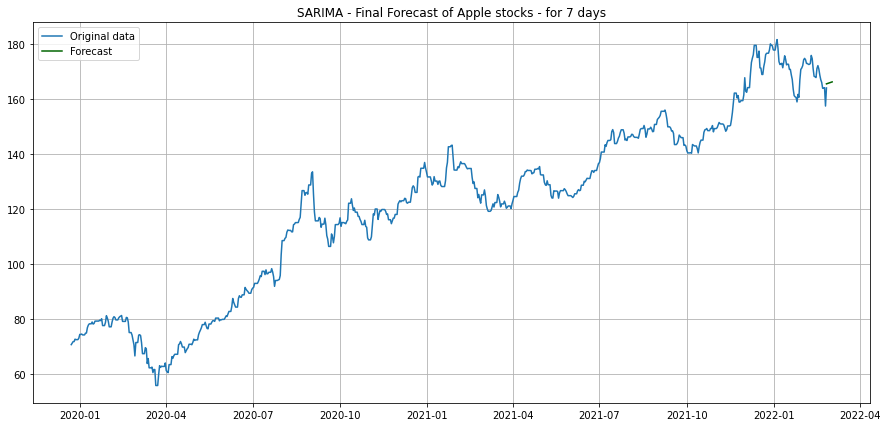

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(data_aggregate, label='Original data')
plt.plot(fitted_series, color='darkgreen', label='Forecast')
plt.title("SARIMA - Final Forecast of Apple stocks - for 7 days")
plt.grid(True)
plt.legend()
plt.show()

Сохранение обученной модели

In [6]:
import pickle

with open('auto_arima.pkl', 'wb') as pkl:
    pickle.dump(smodel_agg, pkl)

Проверка работы на новых данных

In [2]:
import pickle

filename = 'auto_arima.pkl'
with open(filename, 'rb') as pkl:
    loaded_arima = pickle.load(pkl)

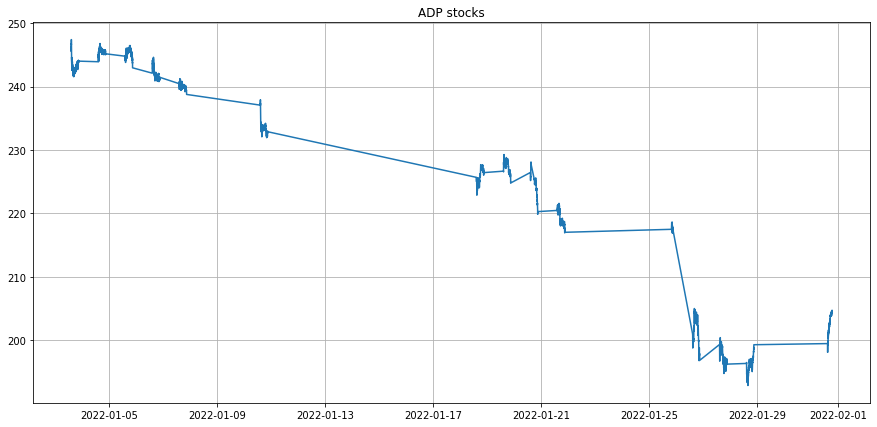

In [4]:
file = 'ADP.csv'
dataset = pd.read_csv(file, index_col=0, parse_dates=[0])
data = dataset.loc[:, 'Adj Close']  # значения акции
data = data.to_frame()
data = data.sort_index()

plt.figure(figsize=(15, 7))
plt.plot(data)
plt.title('ADP stocks')
plt.grid(True)
plt.show()

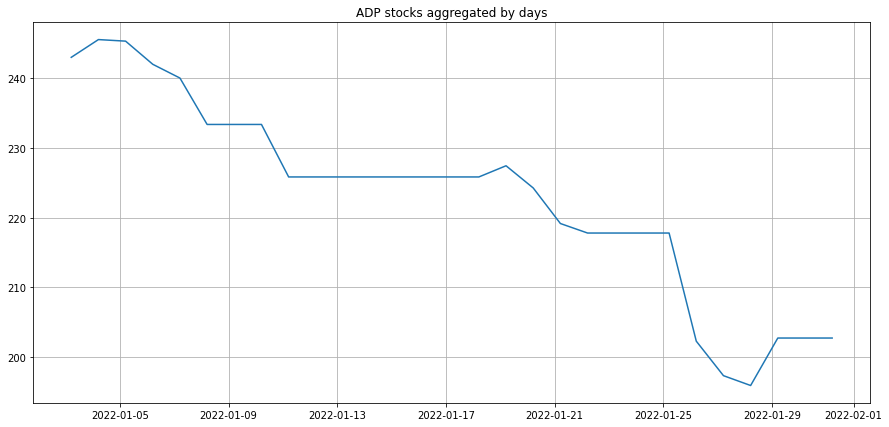

In [5]:
data_aggregate = data.resample('D').mean()
data_aggregate = data_aggregate.fillna(data_aggregate.bfill())
data_aggregate.isnull().sum()

plt.figure(figsize=(15, 7))
plt.plot(data_aggregate)
plt.title('ADP stocks aggregated by days')
plt.grid(True)
plt.show()

In [6]:
loaded_arima.update(data_aggregate)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True)

In [8]:
n_periods = 5
fitted_load, _ = loaded_arima.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(start=data_aggregate.index[-1], periods = n_periods, freq='D')

fitted_series_load = pd.DataFrame(fitted_load, index=index_of_fc, columns=['Value'])

In [9]:
list(fitted_series_load.Value)

[202.8874853136549,
 203.03398933168802,
 203.18049334972113,
 203.32699736775425,
 203.47350138578736]

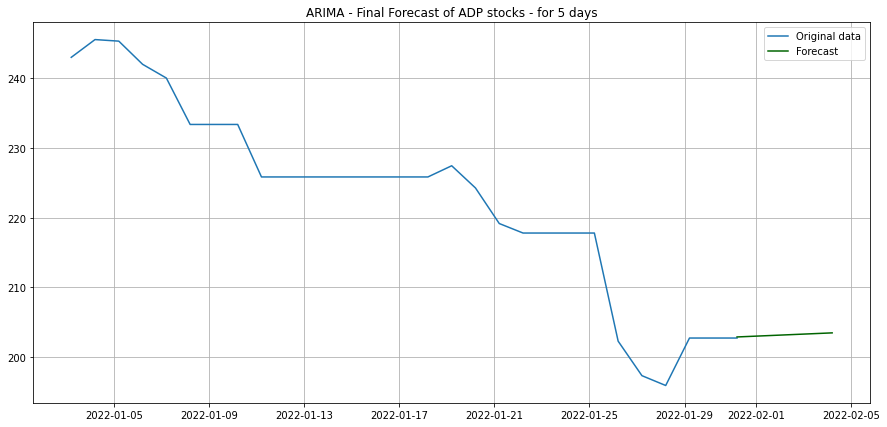

In [11]:
plt.figure(figsize=(15, 7))
plt.plot(data_aggregate, label='Original data')
plt.plot(fitted_series_load, color='darkgreen', label='Forecast')
plt.title("ARIMA - Final Forecast of ADP stocks - for 5 days")
plt.grid(True)
plt.legend()
plt.show()